In [20]:
from numpy import * # the "numpy" library for linear algebra

In [21]:
import matplotlib.pyplot as plt 
%matplotlib inline
# to display pictures

# Backpropagation

## Implement backpropagation for a general (fully connected) network

In [22]:
def net_f_df(z): # calculate f(z) and f'(z)
    val=1/(1+exp(-z))
    return(val,exp(-z)*(val**2)) # return both f and f'

In [23]:
def forward_step(y,w,b): # calculate values in next layer, from input y
    z=dot(y,w)+b # w=weights, b=bias for next layer
    return(net_f_df(z)) # apply nonlinear function and return result

In [24]:
def apply_net(y_in): # one forward pass through the network
    global Weights, Biases, NumLayers
    global y_layer, df_layer # stores y-values and df/dz values
    
    y=y_in # start with input values
    y_layer[0]=y
    for j in range(NumLayers): # loop through all layers [not counting input]
        # j=0 corresponds to the first layer above the input
        y,df=forward_step(y,Weights[j],Biases[j]) # one step, into layer j
        df_layer[j]=df # store f'(z) [needed later in backprop]
        y_layer[j+1]=y # store f(z) [also needed in backprop]        
    return(y)

In [25]:
def apply_net_simple(y_in): # one forward pass through the network

    y=y_in # start with input values
    y_layer[0]=y
    for j in range(NumLayers): # loop through all layers
        # j=0 corresponds to the first layer above the input
        y,df=forward_step(y,Weights[j],Biases[j]) # one step
    return(y)

In [26]:
def backward_step(delta,w,df): 
    # delta at layer N, of batchsize x layersize(N))
    # w between N-1 and N [layersize(N-1) x layersize(N)] matrix
    # df = df/dz at layer N-1, of [batchsize x layersize(N-1)]
    return( dot(delta,transpose(w))*df ) # as explained before 

In [27]:
def backprop(y_target): # one backward pass through the network
    # the result will be the 'dw_layer' matrices that contain
    # the derivatives of the cost function with respect to
    # the corresponding weight
    global y_layer, df_layer, Weights, Biases, NumLayers
    global dw_layer, db_layer # dCost/dw and dCost/db (w,b=weights,biases)
    global batchsize
    
    delta=(y_layer[-1]-y_target)*df_layer[-1]
    dw_layer[-1]=dot(transpose(y_layer[-2]),delta)/batchsize
    db_layer[-1]=delta.sum(0)/batchsize
    for j in range(NumLayers-1):
        delta=backward_step(delta,Weights[-1-j],df_layer[-2-j])
        dw_layer[-2-j]=dot(transpose(y_layer[-3-j]),delta)/batchsize
        db_layer[-2-j]=delta.sum(0)/batchsize

In [28]:
def gradient_step(eta): # update weights & biases (after backprop)
    global dw_layer, db_layer, Weights, Biases
    
    for j in range(NumLayers):
        Weights[j]-=eta*dw_layer[j]
        Biases[j]-=eta*db_layer[j]

In [29]:
def train_net(y_in,y_target,eta): # one full training batch
    # y_in is an array of size batchsize x (input-layer-size)
    # y_target is an array of size batchsize x (output-layer-size)
    # eta is the stepsize for the gradient descent
    global y_out_result
    
    y_out_result=apply_net(y_in)
    backprop(y_target)
    gradient_step(eta)
    cost=0.5*((y_target-y_out_result)**2).sum()/batchsize
    return(cost)

### Train net to reproduce a 2D function

In [30]:
# implement a ReLU unit (rectified linear), which
# works better for training in this case
def net_f_df(z): # calculate f(z) and f'(z)
    val=z*(z>0)
    return(val,z>0) # return both f and f'

In [31]:
# set up all the weights and biases

NumLayers=5 # does not count input-layer (but does count output)
LayerSizes=[2,30,30,30,30,1] # one input layer with two input neurons
# four hidden layers with 30 neurons each

Weights=[random.uniform(low=-0.5,high=+0.5,size=[ LayerSizes[j],LayerSizes[j+1] ]) for j in range(NumLayers)]
Biases=[zeros(LayerSizes[j+1]) for j in range(NumLayers)]

In [32]:
# set up all the variables

y_layer=[zeros(LayerSizes[j]) for j in range(NumLayers+1)]
df_layer=[zeros(LayerSizes[j+1]) for j in range(NumLayers)]
dw_layer=[zeros([LayerSizes[j],LayerSizes[j+1]]) for j in range(NumLayers)]
db_layer=[zeros(LayerSizes[j+1]) for j in range(NumLayers)]

In [33]:
# define the batchsize
batchsize=1000

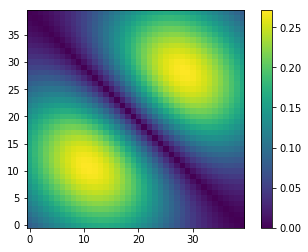

In [34]:
# the function we want to have (desired output)
def myFunc(x0,x1):
    r2=x0**2+x1**2
    return(exp(-5*r2)*abs(x1+x0))

xrange=linspace(-0.5,0.5,40)
X0,X1=meshgrid(xrange,xrange)
plt.imshow(myFunc(X0,X1),interpolation='nearest',origin='lower')
plt.colorbar()
plt.show()

In [39]:
# pick 'batchsize' random positions in the 2D square
def make_batch():
    global batchsize

    inputs=random.uniform(low=-0.5,high=+0.5,size=[batchsize,2])
    targets=zeros([batchsize,1]) # must have right dimensions
    targets[:,0]=myFunc(inputs[:,0],inputs[:,1])
    return(inputs,targets)

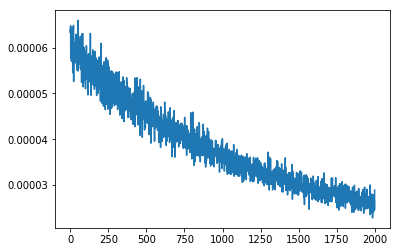

In [40]:
# training network (and plot the cost function)
eta=.1
batches=2000
costs=zeros(batches)

for k in range(batches):
    y_in,y_target=make_batch()
    costs[k]=train_net(y_in,y_target,eta)

plt.plot(costs)
plt.show()


In [41]:
# a 'test' batch that includes all the points on the image grid
test_batchsize=shape(X0)[0]*shape(X0)[1]
testsample=zeros([test_batchsize,2])
testsample[:,0]=X0.flatten()
testsample[:,1]=X1.flatten()

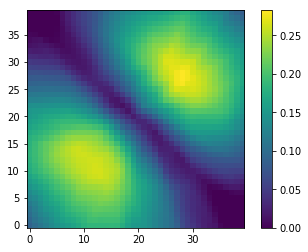

In [43]:
# show the output of this net
testoutput=apply_net_simple(testsample)
myim=plt.imshow(reshape(testoutput,shape(X0)),origin='lower',interpolation='none')
plt.colorbar()
plt.show()